In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans/scripts/')
import barymap as bm
from TensorBasedNN import TBNN
from utilities import mask_boundary_points

# standard datatype
dtype = torch.double

In [32]:
def time():
    return datetime.datetime.now().strftime("%y-%m-%d_%H-%M")

In [3]:
# set path to models and initialise arrays
model_path = 'trained_models/'
model_names = os.listdir(model_path)
print(model_names)
models = []
train_loss = []
val_loss = []

# loop over model names
for i, name in enumerate(model_names):
    models.append(th.load(os.sep.join([model_path, name, 'model.pt'])))
    models[i].eval()  # mandatory, see torch.load doc
    train_loss.append(th.load(os.sep.join([model_path, name, 'loss_vector.th'])))
    val_loss.append(th.load(os.sep.join([model_path, name, 'val_loss_vector.th'])))

['3cases', '4cases']


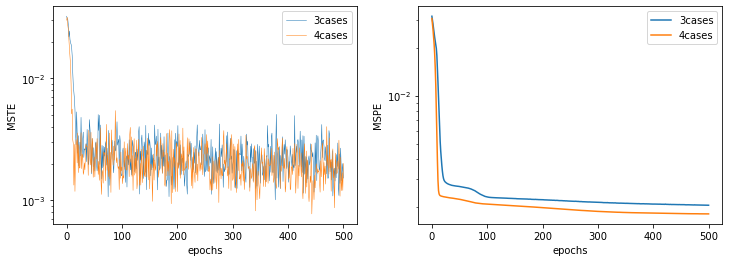

In [4]:
# plot training and validiation error of models
fig, ax = plt.subplots(1,2, figsize=(12,4))

for i,_ in enumerate(train_loss):
    ax[0].semilogy(np.arange(train_loss[i].shape[0]), train_loss[i], linewidth=0.5)
    ax[0].set_xlabel(r'epochs')
    ax[0].set_ylabel(r'MSTE')

    ax[1].semilogy(np.arange(val_loss[i].shape[0]), val_loss[i])
    ax[1].set_xlabel(r'epochs')
    ax[1].set_ylabel(r'MSPE')
    
ax[0].legend(model_names)
ax[1].legend(model_names)

In [77]:
# load in flowcase for testing
test_data_path =  '/home/leonriccius/Documents/Fluid_Data/test_data/periodic_hills/tensordata'
# on workstation: /home/leon/Master_Thesis/Fluid_Data ...
cases = '2800'
curr_case = os.sep.join([test_data_path, cases])

# read in test case tensors
inv_test = th.load(os.sep.join([curr_case,'inv-torch.th']))
T_test = th.load(os.sep.join([curr_case,'T-torch.th'])).reshape(-1,10,9)
b_dns_test = th.load(os.sep.join([curr_case,'b-torch.th']))
b_rans_test = th.load(os.sep.join([curr_case,'b_rans-torch.th']))
grid_test = th.load(os.sep.join([curr_case,'grid-torch.th']))

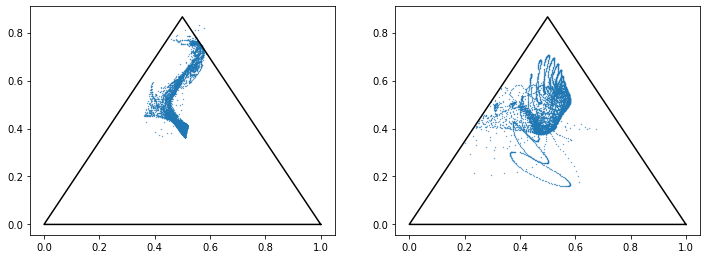

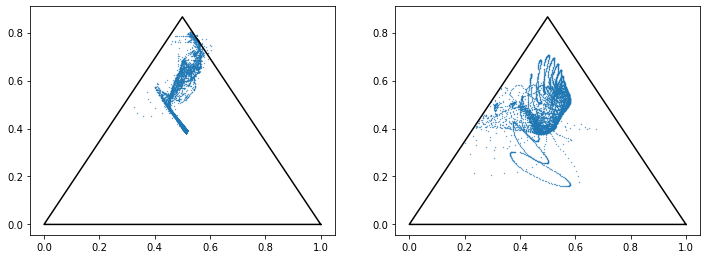

In [27]:
# get barycentric map for models

#loop over models
for i, model in enumerate(models):
    fig, ax = plt.subplots(1,2, figsize=(12,4.2))
    
    #get prediction and plot the datapoints
    b_pred, _ = model(inv_test, T_test)
    barm_pred = bm.BarMap()
    barm_pred.load_from_variable(b_pred.reshape(-1,3,3).detach().numpy(), grid_test)
    barm_pred.calculate_barycentric_coordinates()
    barm_pred.plot_data_points(ax[0])
    barm_pred.plot_triangle(ax[0])
    
    # plot the dns data points
    barm = bm.BarMap()
    barm.load_from_variable(b_dns_test.reshape(-1,3,3).detach().numpy(), grid_test)
    barm.calculate_barycentric_coordinates()
    barm.plot_data_points(ax[1])
    barm.plot_triangle(ax[1])

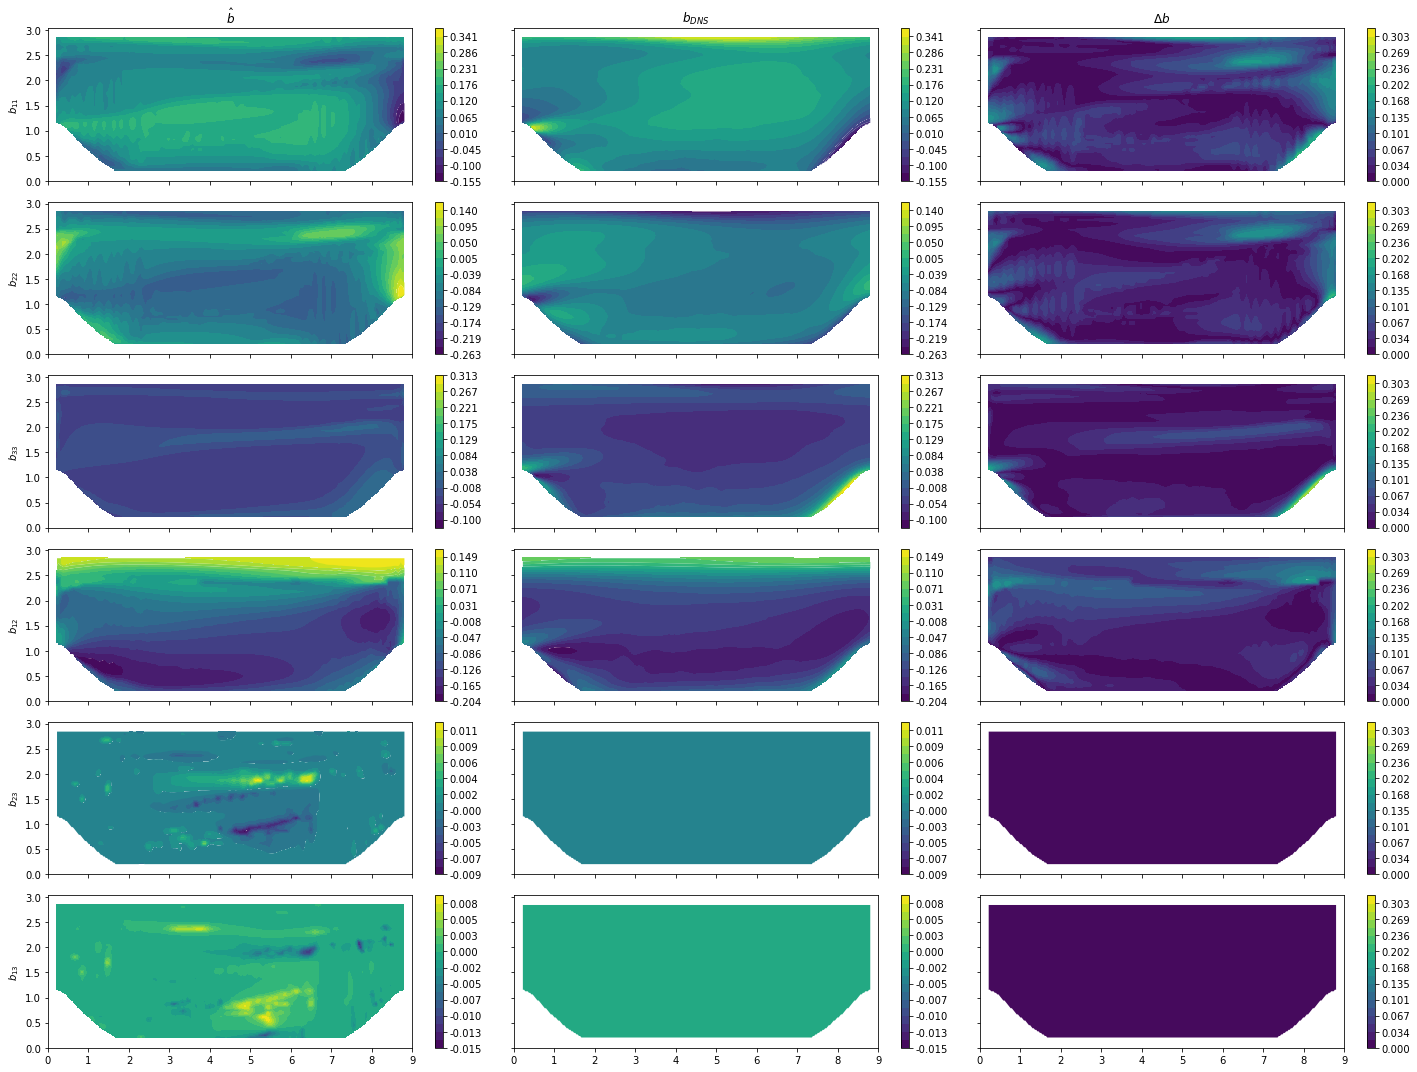

In [79]:
# predicts b for all models and plot the components
# grid for visualisation
grid_x, grid_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]

# get mask for points selection
mask = mask_boundary_points(grid_x, grid_y)

# set path to save figures
fig_path = '/home/leonriccius/gkm/Masters_Thesis/jupyter_notebook/images/NN'
# fig_path = '/home/leonriccius/Desktop'

# for i, model in enumerate(models):
model = models[0]

# get predicted b
b_pred, _ = model(inv_test, T_test)
b_pred = b_pred.reshape(-1,3,3)

# get levels for contourplots
levels_global = np.linspace(-0.3, 0.4, 20) # (-0.2635, 0.3684, 20)
levels_diff = np.linspace(.0, .32, 20)

# create figure
fig, axs = plt.subplots(6,3, figsize=(20, 15), sharex=True, sharey=True, tight_layout=True)
# fig, axs = plt.subplots(6,3, figsize=(20, 15), sharex=True, sharey=True, tight_layout=True)

components = [[0,0], [1,1], [2,2], [0,1], [1,2], [0,2]]

# loop over all 6 unique of b (symmetric), for pred of b, real b, and difference of these two
for i, idx in enumerate(components):
    # interpolate data on grid
    grid_b_pred = griddata(grid_test, b_pred.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    grid_b_test = griddata(grid_test, b_dns_test.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    grid_b_diff = np.abs(grid_b_test - grid_b_pred)
    
    # set unwanted points to Nan
    grid_b_pred[~mask] = float('nan')
    grid_b_test[~mask] = float('nan')
    grid_b_diff[~mask] = float('nan')

    # get min an max of (b_pred, b_test) for colormap
    tmp = th.cat((b_pred[:,idx[0],idx[1]], b_dns_test[:,idx[0],idx[1]])).detach().numpy()
    b_min = np.min(tmp)
    b_max = np.max(tmp)
    levels = np.linspace(b_min, b_max, 20)

    # get the contour plots
    b_nn = axs.flat[3*i].contourf(grid_x, grid_y, grid_b_pred, levels=levels)
    b_dns = axs.flat[3*i+1].contourf(grid_x, grid_y, grid_b_test, levels=levels)
    b_diff = axs.flat[3*i+2].contourf(grid_x, grid_y, grid_b_diff, levels=levels_diff)
    
    # remove contour lines, which otherwise can cause trouble with certain pdf renders
    for contour in [b_nn, b_dns, b_diff]:
        for c in contour.collections:
            c.set_edgecolor("face")
            c.set_linewidth(0.00000000000000001)
    
    # get the colorbars
    fig.colorbar(b_nn, ax=axs.flat[3*i], format='%.3f')
    fig.colorbar(b_dns, ax=axs.flat[3*i+1], format='%.3f')
    fig.colorbar(b_diff, ax=axs.flat[3*i+2], format='%.3f')
    
    # set the component names
    axs[i,0].set_ylabel(r'$b_{'+str(idx[0]+1)+str(idx[1]+1)+'}$')
    
titles = [r'$\hat b$', r'$b_{DNS}$', r'$\Delta b$']
for i in range(3):
    axs[0,i].set_title(titles[i])
    
fig_name = time() + 'phill_' + model_names[0] + '_nn_dns_diff.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

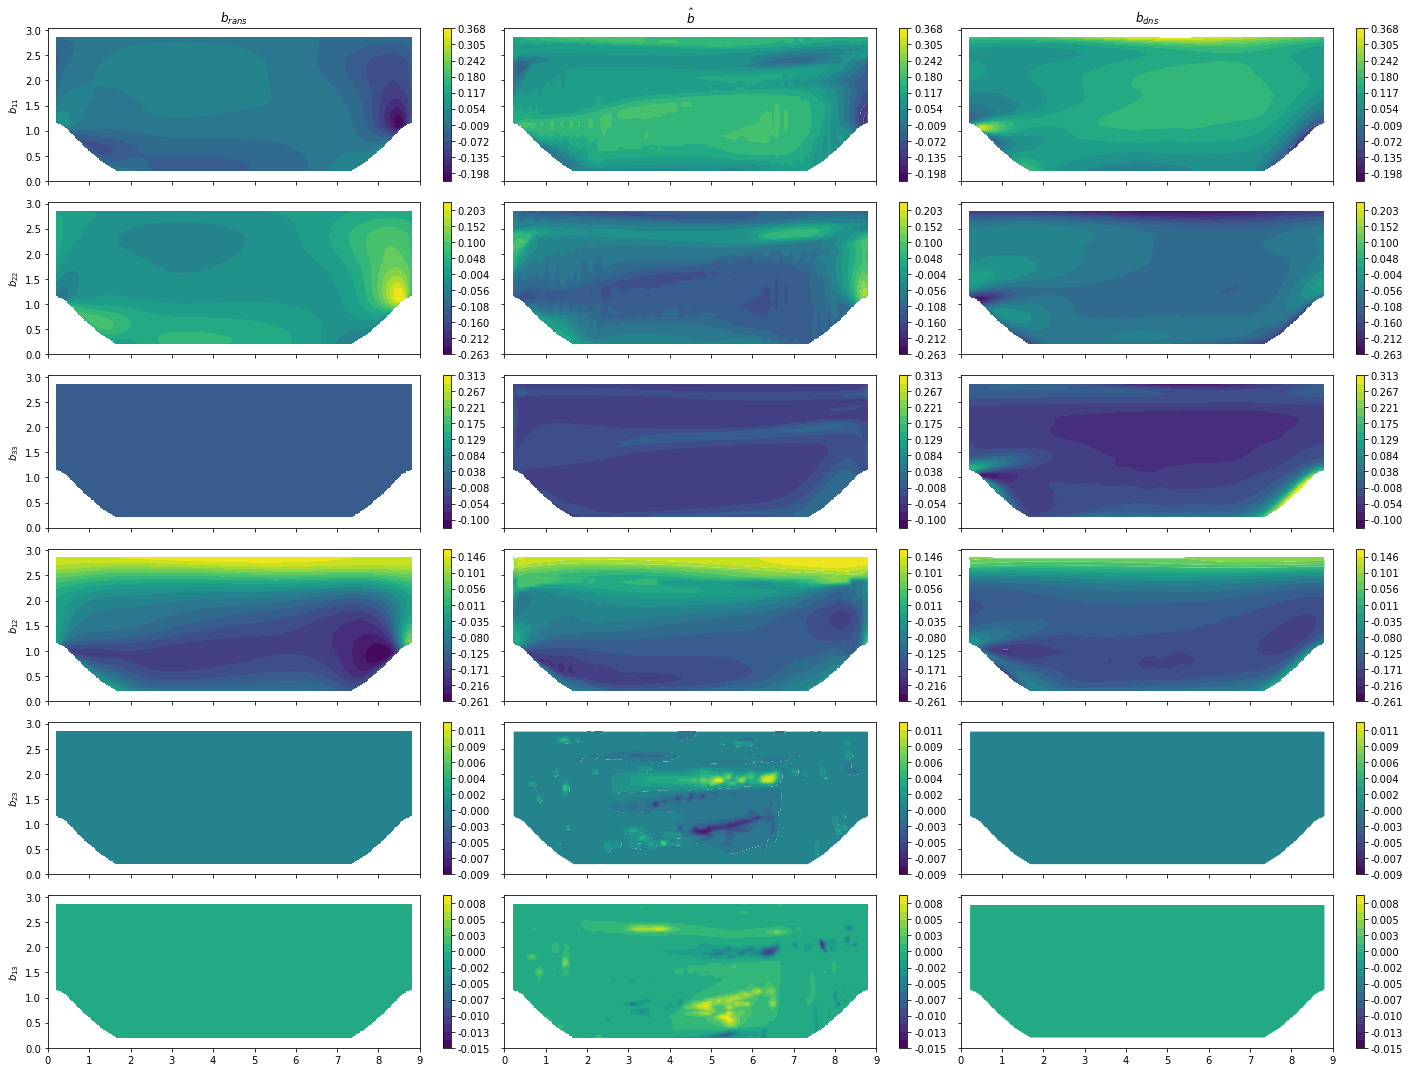

In [82]:
# predicts b for all models and plot the components
# grid for visualisation
grid_x, grid_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]

# get mask for points selection
mask = mask_boundary_points(grid_x, grid_y)

# set path to save figures
fig_path = '/home/leonriccius/gkm/Masters_Thesis/jupyter_notebook/images/NN'
# fig_path = '/home/leonriccius/Desktop'

# for i, model in enumerate(models):
model = models[0]

# get predicted b
b_pred, _ = model(inv_test, T_test)
b_pred = b_pred.reshape(-1,3,3)

# get levels for contourplots
levels_global = np.linspace(-0.3, 0.4, 20) # (-0.2635, 0.3684, 20)
levels_diff = np.linspace(.0, .32, 20)

# create figure
fig, axs = plt.subplots(6,3, figsize=(20, 15), sharex=True, sharey=True, tight_layout=True)
# fig, axs = plt.subplots(6,4, figsize=(20, 15), sharex=True, sharey=True, tight_layout=True)

components = [[0,0], [1,1], [2,2], [0,1], [1,2], [0,2]]

# loop over all 6 unique of b (symmetric), for pred of b, real b, and difference of these two
for i, idx in enumerate(components):
    # interpolate data on grid
    grid_b_rans = griddata(grid_test, b_rans_test.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    grid_b_pred = griddata(grid_test, b_pred.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
    grid_b_test = griddata(grid_test, b_dns_test.detach().numpy()[:,idx[0],idx[1]], (grid_x, grid_y), method='linear')
#     grid_b_diff = np.abs(grid_b_test - grid_b_pred)
    
    # set unwanted points to Nan
    grid_b_rans[~mask] = float('nan')
    grid_b_pred[~mask] = float('nan')
    grid_b_test[~mask] = float('nan')
#     grid_b_diff[~mask] = float('nan')

    # get min an max of (b_pred, b_test) for colormap
    tmp = th.cat((b_rans_test[:,idx[0],idx[1]], b_pred[:,idx[0],idx[1]], b_dns_test[:,idx[0],idx[1]])).detach().numpy()
    b_min = np.min(tmp)
    b_max = np.max(tmp)
    levels = np.linspace(b_min, b_max, 20)

    # get the contour plots
    b_rans = axs.flat[3*i].contourf(grid_x, grid_y, grid_b_rans, levels=levels)
    b_nn = axs.flat[3*i+1].contourf(grid_x, grid_y, grid_b_pred, levels=levels)
    b_dns = axs.flat[3*i+2].contourf(grid_x, grid_y, grid_b_test, levels=levels)

    # remove contour lines
    for contour in [b_nn, b_dns, b_diff]:
        for c in contour.collections:
            c.set_edgecolor("face")
            c.set_linewidth(0.00000000000000001)
    
    # get the colorbars
    fig.colorbar(b_rans, ax=axs.flat[3*i], format='%.3f')
    fig.colorbar(b_nn, ax=axs.flat[3*i+1], format='%.3f')
    fig.colorbar(b_dns, ax=axs.flat[3*i+2], format='%.3f')
    
    
    # set the component names
    axs[i,0].set_ylabel(r'$b_{'+str(idx[0]+1)+str(idx[1]+1)+'}$')
    
titles = [r'$b_{rans}$', r'$\hat b$', r'$b_{dns}$']
for i in range(3):
    axs[0,i].set_title(titles[i])
    
fig_name = time() + 'phill_' + model_names[0] + '_rans_nn_dns.pdf'
plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

In [35]:
fig_name = time() + '_nn_phill_' + model_names[0] + '.svg'
print(os.sep.join([fig_path, fig_name]))

/home/leonriccius/gkm/Masters_Thesis/jupyter_notebook/images/NN/20-11-13_16-22_nn_phill_pred_3cases.svg


In [ ]:
# for bold italic in math context
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
# plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'